Ep 000 | R=8.63 CVaR=5.46 C=0.03 μ=10.00 crashes=18
Ep 010 | R=8.65 CVaR=6.04 C=0.11 μ=10.06 crashes=22
Ep 020 | R=8.95 CVaR=6.26 C=0.05 μ=10.13 crashes=16
Ep 030 | R=8.67 CVaR=5.42 C=0.05 μ=10.19 crashes=26
Ep 040 | R=8.70 CVaR=6.02 C=0.06 μ=10.27 crashes=30
Ep 050 | R=8.81 CVaR=5.65 C=0.02 μ=10.35 crashes=28
Ep 060 | R=8.83 CVaR=6.45 C=0.03 μ=10.44 crashes=34
Ep 070 | R=8.94 CVaR=6.41 C=0.05 μ=10.53 crashes=36
Ep 080 | R=9.00 CVaR=5.42 C=0.08 μ=10.61 crashes=27
Ep 090 | R=8.73 CVaR=4.72 C=0.06 μ=10.69 crashes=35
Ep 100 | R=8.78 CVaR=4.85 C=0.05 μ=10.77 crashes=34
Ep 110 | R=8.50 CVaR=4.31 C=0.12 μ=10.85 crashes=39
Ep 120 | R=8.77 CVaR=4.43 C=0.05 μ=10.93 crashes=34
Ep 130 | R=9.13 CVaR=4.66 C=0.06 μ=11.01 crashes=29
Ep 140 | R=8.87 CVaR=4.43 C=0.06 μ=11.09 crashes=37
Ep 150 | R=8.84 CVaR=5.06 C=0.02 μ=11.17 crashes=35
Ep 160 | R=8.76 CVaR=5.04 C=0.09 μ=11.25 crashes=35
Ep 170 | R=8.58 CVaR=4.40 C=0.05 μ=11.33 crashes=36
Ep 180 | R=9.01 CVaR=4.55 C=0.08 μ=11.40 crashes=31
Ep 190 | R=8

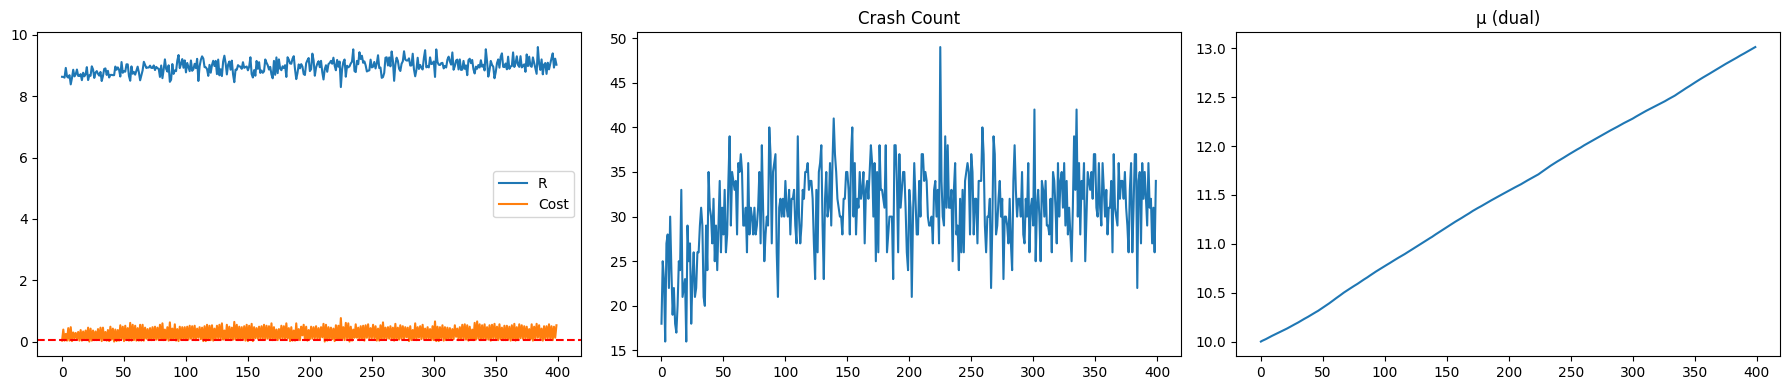

In [4]:
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
import highway_env   # registers roundabout-v0
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

# 1) Hyperparameters
env_id         = "roundabout-v0"
batch_size     = 64          # number of parallel envs
max_steps      = 200
hidden_size    = 256
gamma          = 0.99
alpha          = 0.05
cost_limit     = 0.05
lr_policy      = 3e-4
lr_dual        = 1e-2
entropy_coef   = 0.01
num_epochs     = 400
noise_scale    = 0.01
failure_cap    = 50_000      # capacity of failure buffer
failure_mix    = 0.2         # fraction of failure‐buffer samples per update

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Policy network
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden=hidden_size):
        super().__init__()
        self.fc1    = nn.Linear(obs_dim, hidden)
        self.fc2    = nn.Linear(hidden, hidden)
        self.fc3    = nn.Linear(hidden, hidden)
        self.logits = nn.Linear(hidden, action_dim)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.logits(h)
    def get_dist(self, x):
        return torch.distributions.Categorical(logits=self.forward(x))

# 3) Failure‐only Replay buffer
class FailureBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)
    def push(self, *transition):
        self.buf.append(transition)
    def sample(self, n):
        idx = np.random.choice(len(self.buf), n, replace=False)
        return [self.buf[i] for i in idx]
    def __len__(self):
        return len(self.buf)

# 4) Set up envs, networks, buffers
def make_env(): return gym.make(env_id)
envs = AsyncVectorEnv([make_env for _ in range(batch_size)])

obs_dim    = int(np.prod(envs.single_observation_space.shape))
action_dim = envs.single_action_space.n

policy      = PolicyNet(obs_dim, action_dim).to(device)
opt_pol     = torch.optim.Adam(policy.parameters(), lr=lr_policy)
lambda_cvar = torch.tensor(1.0, requires_grad=True, device=device)
mu_cost     = torch.tensor(10.0,requires_grad=True, device=device)
opt_dual    = torch.optim.Adam([lambda_cvar, mu_cost], lr=lr_dual)

failure_buffer = FailureBuffer(failure_cap)

# 5) CVaR helper
def static_cvar(returns, α):
    sorted_r, _ = returns.sort()
    k           = max(1, int(α * sorted_r.numel()))
    return sorted_r[:k].mean()

# 6) Collect on‐policy batch + record transitions
def collect_batch(envs, policy, max_steps):
    out = envs.reset()
    obs = out[0] if isinstance(out, tuple) else out
    obs = torch.tensor(obs, dtype=torch.float32, device=device).view(batch_size, -1)

    logps_buf, rews_buf = [], []
    crashed   = torch.zeros(batch_size, dtype=torch.bool, device=device)
    done_mask = torch.zeros(batch_size, dtype=torch.bool, device=device)
    transitions = []

    for _ in range(max_steps):
        # FGSM adversary
        obs_adv  = obs.detach().clone().requires_grad_(True)
        dist_adv = policy.get_dist(obs_adv)
        a_adv    = dist_adv.sample()
        loss_adv = -dist_adv.log_prob(a_adv).mean()
        grads    = torch.autograd.grad(loss_adv, obs_adv)[0]
        obs      = (obs_adv + noise_scale * grads.sign()).detach()

        # policy step
        dist     = policy.get_dist(obs)
        acts     = dist.sample()
        logps    = dist.log_prob(acts)

        # step env
        so = envs.step(acts.cpu().numpy())
        if len(so)==5:
            nxt, rews, dones, truncs, infos = so
            dones = np.logical_or(dones, truncs)
        else:
            nxt, rews, dones, infos = so
            dones = np.array(dones)
        done_mask |= torch.tensor(dones, device=device)

        # crash flag
        if isinstance(infos, dict):
            crash_arr = np.array(infos.get("crashed", np.zeros(batch_size)), bool)
        else:
            crash_arr = np.array([bool(i.get("crashed", False)) for i in infos], bool)
        crashed |= torch.tensor(crash_arr, device=device)

        # record
        logps_buf.append(logps)
        rews_buf.append(torch.tensor(rews, dtype=torch.float32, device=device))

        # store transitions
        nxt_t = torch.tensor(nxt, dtype=torch.float32, device=device).view(batch_size, -1)
        for i in range(batch_size):
            transitions.append((
                obs[i].detach().cpu(),    # state
                acts[i].item(),           # action
                logps[i].detach().cpu(),  # old log‐prob
                float(rews[i]),           # reward
                float(crash_arr[i]),      # cost
                nxt_t[i].detach().cpu(),  # next state
                bool(dones[i])            # done
            ))

        # next obs + jitter
        obs = nxt_t + torch.randn_like(nxt_t)*(noise_scale*0.1)
        if done_mask.all():
            break

    # --- HERE: define ep_C and crash_count ---
    ep_C        = crashed.float()                   # per-env cost 0/1
    crash_count = int(crashed.sum().item())

    # assemble returns
    T = len(rews_buf)
    returns = torch.zeros(T, batch_size, device=device)
    G = torch.zeros(batch_size, device=device)
    for t in reversed(range(T)):
        G = rews_buf[t] + gamma * G
        returns[t] = G

    ep_R      = returns[0]
    all_logps = torch.cat(logps_buf)
    all_rets  = returns.flatten()

    return ep_R, ep_C, all_logps, all_rets, crash_count, transitions


# 7) Train‐epoch with alternating failure‐only updates + squared hinge penalty
def train_epoch(envs, policy, ep):
    # 1) rollout on‐policy
    ep_R, ep_C, logps_o, rets_o, crash_count, trans = collect_batch(envs, policy, max_steps)

    # 2) stash *only* crash episodes into the failure buffer
    if crash_count > 0:
        for tr in trans:
            failure_buffer.push(*tr)

    # 3) build on‐policy surrogate & cost
    baseline   = rets_o.mean().detach()
    adv_on     = rets_o - baseline
    loss_on    = - (logps_o * adv_on).mean()
    cost_on    = ep_C.mean()

    # decide whether to do a pure failure‐buffer step this epoch
    use_fail_phase = (ep % 2 == 0) and (len(failure_buffer) >= batch_size)

    if use_fail_phase:
        # --- pure failure‐buffer update ---
        batch = failure_buffer.sample(batch_size)
        s_f, a_f, logp_old, r_f, c_f, nxt_f, d_f = zip(*batch)
        s_f       = torch.stack(s_f).to(device)
        a_f       = torch.tensor(a_f, device=device)
        logp_old  = torch.stack(logp_old).to(device)
        r_f       = torch.tensor(r_f, device=device)
        c_f       = torch.tensor(c_f, device=device)

        dist_f    = policy.get_dist(s_f)
        logp_new  = dist_f.log_prob(a_f)
        with torch.no_grad():
            w = (logp_new - logp_old).exp().clamp(max=10.0)

        # one‐step advantage on failure‐buffer
        adv_f     = r_f - r_f.mean().detach()
        loss_surr = - (w * logp_new * adv_f).mean()
        avg_cost  = c_f.mean()

    else:
        # --- normal on‐policy step ---
        loss_surr = loss_on
        avg_cost  = cost_on

    # 4) worst‐case (CVaR) on returns
    cvar = static_cvar(ep_R, alpha)

    # 5) squared‐hinge crash penalty
    slack       = avg_cost - cost_limit
    hinge_slack = torch.clamp(slack, min=0.0)
    cost_pen    = mu_cost * hinge_slack**2

    # 6) Lagrangian policy update
    L = loss_surr - lambda_cvar * cvar + cost_pen
    opt_pol.zero_grad()
    L.backward()
    torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=0.5)
    opt_pol.step()

    # 7) dual ascent on μ (maximize μ⋅hinge_slack²)
    opt_dual.zero_grad()
    dual_loss = - mu_cost * hinge_slack**2
    dual_loss.backward()
    opt_dual.step()
    mu_cost.data.clamp_(0.0, 50.0)

    return (
        ep_R.mean().item(),
        cvar.item(),
        avg_cost.item(),
        mu_cost.item(),
        crash_count
    )


# 8) Main loop + logging
logs = []
for ep in range(num_epochs):
    R, CVaR, C, mu, crashes = train_epoch(envs, policy, ep)
    logs.append((R, CVaR, C, mu, crashes))
    if ep % 10 == 0:
        print(f"Ep {ep:03d} | R={R:.2f} CVaR={CVaR:.2f}"
              f" C={C:.2f} μ={mu:.2f} crashes={crashes}")


print("Total time:", time.time() - t0)

# 9) Plot
df = pd.DataFrame(logs, columns=["R","CVaR","Cost","μ","crashes"])
fig,ax = plt.subplots(1,3,figsize=(18,4))
df[["R","Cost"]].plot(ax=ax[0]); ax[0].axhline(cost_limit, ls='--', c='r')
df["crashes"].plot(ax=ax[1]); ax[1].set_title("Crash Count")
df["μ"].plot(ax=ax[2]); ax[2].set_title("μ (dual)")
plt.tight_layout()
plt.show()


In [5]:
torch.save(policy.state_dict(), "REPCO3.pt")